In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import json

2024-01-08 17:14:26.393740: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 17:14:26.419807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the model

In [2]:
trained_CNN = tf.keras.models.load_model('./TrainedCNNs/for_test_v2')
trained_CNN.trainable = True
trained_CNN.summary()

2024-01-08 17:14:27.371552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 17:14:27.483626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 17:14:27.483847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [3]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(trained_CNN.layers))
# Fine-tune before this layer onwards

#print(trained_CNN.layers[13].name)
#trained_CNN.layers[11].trainable = True
#trained_CNN.layers[12].trainable = True
#trained_CNN.layers[13].trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(trained_CNN.layers))

# Fine-tune from this layer onwards
fine_tune_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in trained_CNN.layers[:fine_tune_at]:
    layer.trainable = False


trained_CNN.layers[-1].trainable = False

trained_CNN.summary()

Number of layers in the base model:  17
Number of layers in the base model:  17
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                               

In [4]:
def load_images_from_folder(directory):
    images = []
    fileslist = os.listdir(directory)
    fileslist = sorted(fileslist , key = lambda fileslist: int(fileslist.split('.')[0]))
    for filename in fileslist:
        #img = cv.imread(os.path.join(directory,filename))
        loc = os.path.join(directory,filename)
        img = tf.keras.preprocessing.image.load_img(loc, target_size=(300, 300))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        if img is not None:
            images.append(img)
    return np.asarray(images)

In [5]:
def load_angles_from_folder(directory):
    with open(directory,'r')  as ff:
        content = ff.readline()
        angles = content.split(sep='\t') #lines are separated by tabs
        angles = np.asarray(angles, dtype = np.float32) * (np.pi/180)
        return angles

In [6]:
directory_imgs = './Dataset/imgs/'
directory_angles = './Dataset/Labels.txt'
imgs = load_images_from_folder(directory_imgs)
angles = load_angles_from_folder(directory_angles)

In [7]:
print(len(trained_CNN.trainable_variables))
opt = tf.keras.optimizers.Adam(learning_rate = 1e-7)
lossfunction = tf.keras.losses.MeanSquaredError()
trained_CNN.compile(optimizer = opt, loss = lossfunction, metrics = ['MeanAbsoluteError'])
#trained_CNN.summary()

4


In [8]:
history = trained_CNN.fit(imgs[0:900], angles[0:900], validation_split = 0.1, epochs = 150, batch_size = 16)

Epoch 1/150


2024-01-08 17:14:30.986347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-01-08 17:14:32.991327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-08 17:14:33.602117: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x84aa3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-08 17:14:33.602138: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-08 17:14:33.604745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-08 17:14:33.694173: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

51/51 [==============================] - 9s 124ms/step - loss: 0.0056 - mean_absolute_error: 0.0553 - val_loss: 0.0100 - val_mean_absolute_error: 0.0774
Epoch 2/150
51/51 [==============================] - 5s 91ms/step - loss: 0.0056 - mean_absolute_error: 0.0554 - val_loss: 0.0101 - val_mean_absolute_error: 0.0773
Epoch 3/150
51/51 [==============================] - 5s 93ms/step - loss: 0.0054 - mean_absolute_error: 0.0543 - val_loss: 0.0101 - val_mean_absolute_error: 0.0771
Epoch 4/150
51/51 [==============================] - 5s 93ms/step - loss: 0.0053 - mean_absolute_error: 0.0539 - val_loss: 0.0099 - val_mean_absolute_error: 0.0771
Epoch 5/150
51/51 [==============================] - 5s 96ms/step - loss: 0.0054 - mean_absolute_error: 0.0540 - val_loss: 0.0101 - val_mean_absolute_error: 0.0769
Epoch 6/150
51/51 [==============================] - 5s 93ms/step - loss: 0.0052 - mean_absolute_error: 0.0531 - val_loss: 0.0100 - val_mean_absolute_error: 0.0766
Epoch 7/150
51/51 [========

In [9]:
trained_CNN.save('./TrainedCNNs/for_test(fine_tunned)_corr', save_format = 'h5' )

/home/shayan/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
import json
# Save the history to a JSON file
history_dict_finetuning_best = history.history

# Specify the file path
file_path = './Training_History_Files/for_test_fine_tunned_corr.json'

# Convert the dictionary to a JSON string and save it to the file
with open(file_path, 'w') as json_file:
    json.dump(history_dict_finetuning_best, json_file)

print(f"Training history saved to {file_path}")


Training history saved to ./Training_History_Files/for_test_fine_tunned_corr.json


In [11]:
file_path = './Training_History_Files/for_test_fine_tunned_corr.json'
history_dict = json.load(open(file_path, 'r'))

#print(history_dict)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


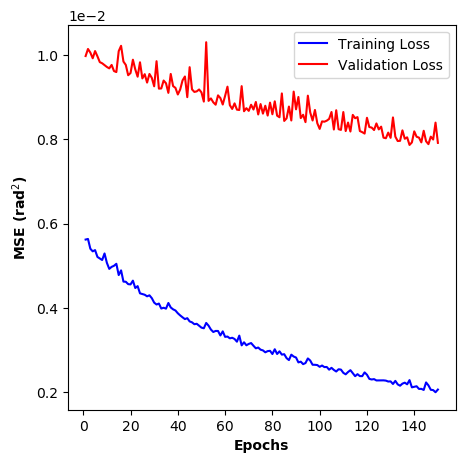

In [12]:
'''font = {'weight' : 'bold', 'size' : 10}
plt.rc ('font', **font)'''


figure1 = plt.figure(figsize=(5,5))
MeanSquareError =np.array(history_dict['loss'])
SampleNo = np.arange(1,len(MeanSquareError) + 1)
MeanSquareError_val =np.array(history_dict['val_loss'])


plt.plot(SampleNo, MeanSquareError , color = 'blue')
plt.plot(SampleNo, MeanSquareError_val , color = 'red')
plt.xlabel('Epochs' , fontsize = 10 , weight='bold')
plt.ylabel(r'MSE (rad$^2$)' , fontsize = 10 , weight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('./Results_Paper/training_loss_fine_tunned.eps', format='eps')